<a href="https://colab.research.google.com/github/Chirag314/EDA/blob/main/spaceship_titanic3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

######Reference 
https://www.kaggle.com/code/javigallego/titanic-spaceship-eda/notebook?scriptVersionId=90210061


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('display.expand_frame_repr', False)
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)


from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
#from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
pd.set_option('max_rows',None)

In [3]:
#Helper functions

#Create function for missing data analysis
def draw_missing_data_table(df):
  total=df.isnull().sum().sort_values(ascending=False)
  percent=(df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  missing_data=pd.concat([total,percent],axis=1,keys=['Total','Percent'])
  return missing_data

In [4]:
#Plot learning curve
def plot_learning_curve(estimator, title, x,y,ylim=None, cv=None,n_jobs=1,train_sizes=np.linspace(.1,1,5)):
  plt.figure()
  plt.title(title)
  if ylim is not None:
    plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator,x,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes)
    train_scores_mean=np.mean(train_scores,axis=1)
    train_scores_std=np.std(train_scores,axis=1)
    test_scores_mean=np.mean(test_scores,axis=1)
    test_scores_std=np.std(test_scores,axis=1)
    plt.grid()
    plt.fill_between(train_sizes,train_scores_mean-train_scores_std,train_scores_mean+train_scores_std,alpha=0.1,color='g')
    plt.plot(train_sizes,train_scores_mean,'o-',color='r',label="Training score")
    plt.plot(train_sizes,test_scores_mean,'o-',color='g',label='Validation score')
    plt.legend(loc="best")
    return plt

In [5]:
#plot validation curve
def plot_validation_curve(estimator, title,x,y,param_name,param_range,ylim=None,cv=None,n_jobs=1,train_sizes=np.linspace(.1,1,5)):
  train_scores,test_scores=validation_curve(estimator,x,y,param_name,param_range,cv)
  train_mean=np.mean(train_scores,axis=1)
  train_std=np.std(train_scores,axis=1)
  test_mean=np.mean(test_scores,axis=1)
  test_std=np.std(test_scores,axis=1)
  plt.plot(param_range,train_mean,color='r',marker='o',markersize=5,label='Training Score')
  plt.fill_between(param_range,train_mean+train_std,train_mean-train_std,alpha=0.15,color='r')
  plt.plot(param_range,test_mean,color='g',linstyle='--',marker='s',markersize=5,label='Validation score')
  plt.fill_between(param_range, test_mean+test_std, test_mean-test_std,alpha=0.15,color='g')
  plt.grid()
  plt.xscale('log')
  plt.legend(loc='best')
  plt.xlabel('Parameter')
  plt.ylabel('Score')
  plt.ylim(ylim)

In [6]:
#get path from training and test data
curr_path = os.getcwd()
dataset_src=os.path.join(curr_path,'spaceship titanic')
train_path=os.path.join(dataset_src,'train.csv')
test_path=os.path.join(dataset_src,'test.csv')

In [7]:
#import data
train_df=pd.read_csv(train_path)
test_df=pd.read_csv(test_path)
df=pd.read_csv('train.csv')
df_raw=df.copy()
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Exploratory Data Analysis
Not all features provide necessary information for the model. It is essentil to find out important features for analysis.


In [8]:
# Check for missing values
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [9]:
# Define the function that creates missing value heatmap
def plot_missing_data(dataset, title):
  fig,ax=plt.subplots(figsize=(5,5))
  plt.title(title)
  sns.heatmap(dataset,cbar=False)

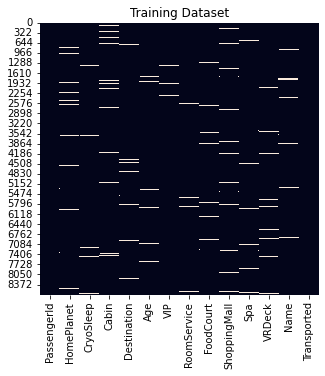

In [10]:
plot_missing_data(df.isnull(),"Training Dataset")

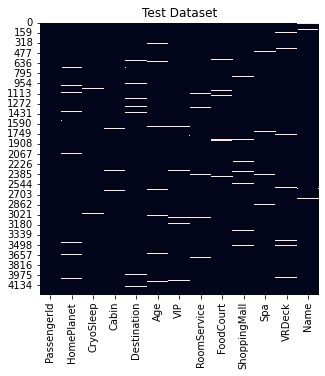

In [11]:
plot_missing_data(test_df.isnull(),"Test Dataset")

In [12]:
# Check number of  missing values in each columns
draw_missing_data_table(train_df)

,Total,Percent
CryoSleep,217,0.024963
ShoppingMall,208,0.023927
VIP,203,0.023352
HomePlanet,201,0.023122
Name,200,0.023007
Cabin,199,0.022892
VRDeck,188,0.021627
FoodCourt,183,0.021051
Spa,183,0.021051
Destination,182,0.020936


In [13]:
# Check features belonging to object category

train_df.select_dtypes(['object']).head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,False,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,False,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,True,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,False,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,False,Willy Santantines


In [14]:
# Impute missing values for Homeplanet
def filling_HomePlanet(df):
  mode=df['HomePlanet'].value_counts().index[0]
  df['HomePlanet']=df['HomePlanet'].fillna(mode)
  return df

In [15]:
# define function for imputing missing values of cryosleep
#if passenger had elected to put himself into suspended animation rarely it would have a missing value, we are going to consider the option of replacing missing values with False in this case.
def filling_CryoSleep(df):
  df['CryoSleep']=df['CryoSleep'].fillna(False)
  return df

######Cabin. As it is shown in the report this feature is categorical. As it is almost impossible to estimate cabin number for a passenger with given format, we are going to split cabin number into three different features. Those are going to be describing: desk, number and side. Thus, we'll start Feature Engineering here (continued in detail subsequently). Next, we are going to replace missing values for deck type feature with F (most repeated value). Hereafter, we are going to fill side feature with most repeated value into decks of type F. Finally, we are going to fill cabin number with half of the maximum cabin number (as cabins belonging to one deck type could have more survival rate whether they are one of the first/last cabin).

In [16]:
#Cabin

def split_Cabin(df):
    df['Deck'] = df['Cabin'].str.split("/", n=2, expand=True)[0]
    df['Number'] = df['Cabin'].str.split("/", n=2, expand=True)[1]
    df['Side'] = df['Cabin'].str.split("/", n=2, expand=True)[2]
    df.pop('Cabin')
    return df

def filling_cabin(df):
  df['Deck']=df['Deck'].fillna('F')
  mode=df[df.Deck=='F']['Side'].value_counts().index[0]
  df['Side']=mode
  df['Number']=df['Number'].astype(float)
  df['Number']=df['Number'].fillna(1976/2)
  return df

In [17]:
#trian_df=split_Cabin(train_df)
#train_df = filling_cabin(train_df)
#train_df.head()

In [18]:
# Destination. planet the passenger will be debarking to
# We will impute missing values with most repeated value

def filling_destination(df):
  mode=df['Destination'].value_counts().index[0]
  df['Destination']=df['Destination'].fillna(mode)
  return df

In [19]:
#VIP- weather the passenger has paid for special VIP service during the voyage
# VIP service deal has not been taken into data collection so replave missing values with faluse

def filling_vip(df):
  df['VIP']=df['VIP'].fillna(False)
  return df

In [20]:
#Name the first and last name of the passenger
# Replace missing values with none as name must be unique and we can not guess it

def filling_name(df):
  df['Name']=df['Name'].fillna('None')
  return df

In [21]:
# Define a function to call all categorical feature missing value imputation functions as defined above

def filling_categorical(df):
  df = filling_HomePlanet(df)
  df = filling_CryoSleep(df)
  df = split_Cabin(df)
  df = filling_cabin(df)
  df = filling_destination(df)
  df = filling_vip(df)
  df = filling_name(df)
  return df

In [22]:
# Check continuous features


In [23]:
train_df.select_dtypes(['float64']).head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,39.0,0.0,0.0,0.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0
4,16.0,303.0,70.0,151.0,565.0,2.0


In [24]:
# Impute age with median

def filling_age(df):
  median = df['Age'].describe()[5]
  df['Age']=df['Age'].fillna(median)
  return df

In [25]:
# Impute all other luxury features
def filling_luxury_features(df):
  luxury_features=['RoomService', 'FoodCourt', 'ShoppingMall','Spa','VRDeck']
  df[luxury_features]=df[luxury_features].fillna(0)
  return df


In [26]:
# Impute all continuous features

def filling_numerical(df):
  df = filling_age(df)
  df = filling_luxury_features(df)
  return df

In [27]:
# Finallly create a function that calls both categorical and continuous function

def filling_missing(df):
  df = filling_categorical(df)
  df = filling_numerical(df)
  return df

# Call function on train data
train_df = filling_missing(train_df)

In [37]:
# Feature engineering
# Base model

def score_dataset(x, y, model=XGBClassifier(label_encoder=False)):
  for colname in x.select_dtypes(['object', 'bool']).columns:
    x[colname] = LabelEncoder().fit_transform(x[colname])
    y['Transported'] = LabelEncoder().fit_transform(y['Transported'])
    score_xgb=cross_val_score(model,x,y,cv=5,scoring='accuracy',n_jobs=-1)
    score=score_xgb.mean()
    return score
  
x=train_df[train_df.Transported.isnull()==False].copy()
y=pd.DataFrame(x.pop('Transported'))
baseline_score=score_dataset(x,y)
print(f'Baseline score : {baseline_score : .5f} Accuracy')
train_df.head()

Baseline score :  nan Accuracy


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py", line 726, in fit
    missing=self.missing, nthread=self.n_jobs)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/core.py", line 380, in __init__
    feature_types)
  File "/usr/local/lib/python3.7/dist-packages/xgboost/core.py", line 239, in _mayb

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Number,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0.0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0.0,P
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0.0,P
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0.0,P
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1.0,P


In [ ]:
# check PassengerId
# Convert passengerid from object to int
from sklearn import preprocessing
lb=preprocessing.LabelEncoder()
train_df['PassengerId']=lb.fit_transform(train_df['PassengerId'])
train_df['PassengerId'].head()

0    0
1    1
2    2
3    3
4    4
Name: PassengerId, dtype: int64

In [ ]:
train_df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [ ]:
# Fill missing values with 0 temporarily
train_df.HomePlanet=train_df.HomePlanet.fillna('0')
train_df.Cabin= train_df.Cabin.fillna(0)
train_df.CryoSleep=train_df.CryoSleep.fillna(0)
train_df.Destination=train_df.Destination.fillna('0')
train_df.Age= train_df.Age.fillna(0)
train_df.VIP=train_df.VIP.fillna(0)
train_df.RoomService=train_df.RoomService.fillna(0)
train_df.FoodCourt=train_df.FoodCourt.fillna(0)
train_df.ShoppingMall=train_df.ShoppingMall.fillna(0)
train_df.Spa=train_df.Spa.fillna(0)
train_df.VRDeck=train_df.VRDeck.fillna(0)
train_df.Name=train_df.Name.fillna('0')

In [ ]:
train_df.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   int64  
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   object 
 3   Cabin         8693 non-null   object 
 4   Destination   8693 non-null   object 
 5   Age           8693 non-null   float64
 6   VIP           8693 non-null   object 
 7   RoomService   8693 non-null   float64
 8   FoodCourt     8693 non-null   float64
 9   ShoppingMall  8693 non-null   float64
 10  Spa           8693 non-null   float64
 11  VRDeck        8693 non-null   float64
 12  Name          8693 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), int64(1), object(6)
memory usage: 891.5+ KB


In [ ]:
features=['PassengerId', 'HomePlanet', 'CryoSleep','Cabin',
          'Destination','Age','VIP','RoomService','FoodCourt',
          'ShoppingMall','Spa','VRDeck','Name','Transported']

In [ ]:
# Convert all float values to integer
train_df.RoomService=train_df.RoomService.astype(int)
train_df.Age=train_df.Age.astype(int)
train_df.FoodCourt=train_df.FoodCourt.astype(int)
train_df.ShoppigMall=train_df.ShoppingMall.astype(int)
train_df.Spa=train_df.Spa.astype(int)
train_df.VRDeck=train_df.VRDeck.astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


In [ ]:
# Remove unnecessary strings from Destination
train_df.Destination= train_df.Destination.replace({'TRAPPIST-1e':'TRAPPIST',
                                                    '55 Cancri e':'Cancri',
                                                    'PSO J318.5-22':'PSO'})
#train_df.Destination.head()
# Convert boolean to integer for Transported
train_df.Transported=train_df.Transported.replace(True,1).replace(False,0)
train_df.Transported.head()

0    0
1    1
2    0
3    0
4    1
Name: Transported, dtype: int64

In [ ]:
#x=train_df[features]
x=train_df.drop(columns=["Cabin" , 'Name', 'Transported'])


In [ ]:
y=train_df["Transported"]

In [ ]:
x['Destination'].unique()
x.iloc[:,3].unique()

array(['TRAPPIST', 'PSO', 'Cancri', '0'], dtype=object)

In [ ]:
# Define arrays for nominal , ordinal, numeric and binary variables
nom=[1,2,3,5]
num=[0,6,7,8,9,10]
bin=[4]

In [ ]:
# Tranform columns based on type
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,PowerTransformer,Binarizer
from sklearn.compose import make_column_transformer
from sklearn import set_config

trans=make_column_transformer((OneHotEncoder(sparse=False),nom),
                               (PowerTransformer(),num),
                               (Binarizer(),bin),
                               remainder='passthrough')
set_config(display='diagram')
trans

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder', OneHotEncoder(sparse=False),
                                 [1, 2, 3, 5]),
                                ('powertransformer', PowerTransformer(),
                                 [0, 6, 7, 8, 9, 10]),
                                ('binarizer', Binarizer(), [4])])

In [ ]:
x_train,x_test, y_train, y_test=train_test_split(x,y,test_size=0.75)

In [ ]:
from sklearn.pipeline import make_pipeline
log=LogisticRegression(solver='liblinear')
pipe=make_pipeline(trans,log)
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  [1, 2, 3, 5]),
                                                 ('powertransformer',
                                                  PowerTransformer(),
                                                  [0, 6, 7, 8, 9, 10]),
                                                 ('binarizer', Binarizer(),
                                                  [4])])),
                ('logisticregression', LogisticRegression(solver='liblinear'))])

In [ ]:
pipe.fit(x_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  [1, 2, 3, 5]),
                                                 ('powertransformer',
                                                  PowerTransformer(),
                                                  [0, 6, 7, 8, 9, 10]),
                                                 ('binarizer', Binarizer(),
                                                  [4])])),
                ('logisticregression', LogisticRegression(solver='liblinear'))])

In [ ]:
pred=pipe.predict(x_test)
pred

array([0, 1, 1, ..., 1, 0, 1])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(pred,y_test)*100

75.47546012269939

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


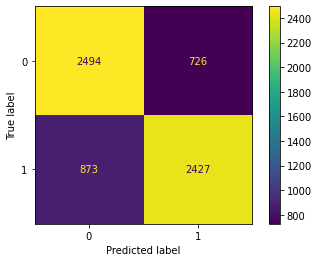

In [ ]:

from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipe,x_test,y_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


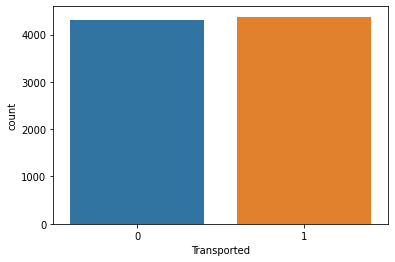

In [ ]:
sns.countplot(y)

In [ ]:
y.value_counts()

1    4378
0    4315
Name: Transported, dtype: int64

In [ ]:
# Balance dataset
from imblearn.over_sampling import RandomOverSampler, SMOTE
over=RandomOverSampler()
ox,oy=over.fit_resample(x,y)
oy.value_counts()

0    4378
1    4378
Name: Transported, dtype: int64

In [ ]:
from imblearn.pipeline import make_pipeline
s=SMOTE()
pipe_s=make_pipeline(trans,s,log)
pipe_s.fit(x_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  [1, 2, 3, 5]),
                                                 ('powertransformer',
                                                  PowerTransformer(),
                                                  [0, 6, 7, 8, 9, 10]),
                                                 ('binarizer', Binarizer(),
                                                  [4])])),
                ('smote', SMOTE()),
                ('logisticregression', LogisticRegression(solver='liblinear'))])

In [ ]:
pred_s=pipe_s.predict(x_test)
accuracy_score(pred_s,y_test)*100


75.49079754601226

In [ ]:
from sklearn.svm import SVC
algorithm=SVC()
pipe_a=make_pipeline(trans,s,algorithm)
pipe_a.fit(x_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  [1, 2, 3, 5]),
                                                 ('powertransformer',
                                                  PowerTransformer(),
                                                  [0, 6, 7, 8, 9, 10]),
                                                 ('binarizer', Binarizer(),
                                                  [4])])),
                ('smote', SMOTE()), ('svc', SVC())])

In [ ]:
pred_a=pipe_a.predict(x_test)

In [ ]:
accuracy_score(pred_a,y_test)*100

75.81288343558282

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb=GradientBoostingClassifier()
pipe_gb=make_pipeline(trans,s,gb)
pipe_gb.fit(x_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  [1, 2, 3, 5]),
                                                 ('powertransformer',
                                                  PowerTransformer(),
                                                  [0, 6, 7, 8, 9, 10]),
                                                 ('binarizer', Binarizer(),
                                                  [4])])),
                ('smote', SMOTE()),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

In [ ]:
pred_gb=pipe_gb.predict(x_test)
accuracy_score(pred_gb,y_test)*100

79.34049079754601

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


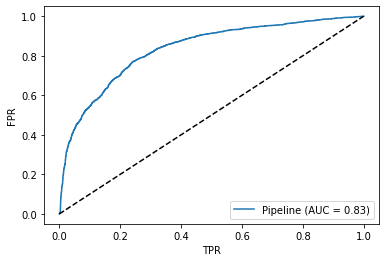

In [ ]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(pipe_a,x_test,y_test)
plt.plot([0,1],[0,1],"k--")#k- color of diagonal
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.show()



In [ ]:
# Test dta
test=pd.read_csv("test.csv")
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [ ]:
test.iloc[:,3].unique()

array(['G/3/S', 'F/4/S', 'C/0/S', ..., 'D/296/P', 'D/297/P', 'G/1498/S'],
      dtype=object)

In [ ]:
test.Destination = test_data.Destination.replace({'TRAPPIST-1e':'TRAPPIST','55 Cancri e':'Cancri','PSO J318.5-22':'PSO'})

In [ ]:
# Check null values in test data
test.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [ ]:
test.HomePlanet=test.HomePlanet.fillna('0')
test.CryoSleep=test.CryoSleep.fillna(0)
test.Cabin=test.Cabin.fillna(0)
test.Destination=test.Destination.fillna('0')
test.Age=test.Age.fillna(0)
test.VIP = test.VIP.fillna(0)
test.RoomService = test.RoomService.fillna(0)
test.FoodCourt = test.FoodCourt.fillna(0)
test.ShoppingMall = test.ShoppingMall.fillna(0)
test.Spa = test.Spa.fillna(0)
test.VRDeck = test.VRDeck.fillna(0)
test.Name = test.Name.fillna('0')

In [ ]:
# Contert test data type as converted in training data
test.RoomService=test.RoomService.astype(int)
test.Age=test.Age.astype(int)
test.FoodCourt=test.FoodCourt.astype(int)
test.ShoppingMall=test.ShoppingMall.astype(int)
test.Spa=test.Spa.astype(int)
test.VRDeck=test.VRDeck.astype(int)

In [ ]:
x1=test.drop(columns=['Cabin','Name'])

In [ ]:
# Encode labels for passenger id in test data
x1.PassengerId=lb.fit_transform(x1.PassengerId)
x1.PassengerId.head()

0    0
1    1
2    2
3    3
4    4
Name: PassengerId, dtype: int64

In [ ]:
x1.iloc[:,5].unique()

array([False, True], dtype=object)

In [ ]:
trans=make_column_transformer((OneHotEncoder(sparse=False),nom),
                              (PowerTransformer(),num),
                              (Binarizer(),bin),
                              remainder='passthrough')
set_config(display='diagram')
trans

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder', OneHotEncoder(sparse=False),
                                 [1, 2, 3, 5]),
                                ('powertransformer', PowerTransformer(),
                                 [0, 6, 7, 8, 9, 10]),
                                ('binarizer', Binarizer(), [4])])

In [ ]:
pred_test=pipe_gb.predict(test)
pred_test

array([1, 0, 1, ..., 1, 1, 0])

In [ ]:
submit=pd.read_csv('submission.csv')
submit.head()

FileNotFoundError: ignored

In [ ]:
submit=pd.DataFrame({
    'PassengerId':test['PassengerId'],
    'Transported':pred_test.astype('bool')
})
submit.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [ ]:
submit.to_csv("Submission_gb.csv", index=False)